In [1]:
from itertools import count
import json
from warnings import simplefilter
import random
import pickle

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from termcolor import colored, cprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy as sp
from scipy import stats

import pymc3 as pm
import arviz as az
import abyes as ab
import statsmodels.stats.api as sms

for w in (DeprecationWarning, FutureWarning):
    simplefilter(action='ignore', category=w)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Simulation
Generate trajectories_h0: at each time step, gather new data, and compute the p-value and a bayesian decision criterion.

The setup is an A/B test with binary outcome.

In [2]:
def bayesian_analysis(samples_a, samples_b):
    exp = ab.AbExp(decision_var = 'lift', rule='rope', rope=(-0.05,0.05), plot=False, verbose=False)
    posterior = exp.find_posterior([samples_a, samples_b])
    decision = exp.decision(posterior)
    hpd = exp.hpd(posterior, 'lift')
    
    return {
        'hpd_lower': hpd.min(),
        'hpd_upper': hpd.max(),
        'decision': decision,
    }

In [3]:
def frequentist_analysis(samples_a, samples_b):
    _, pvalue = stats.fisher_exact([
        [(samples_a == 0).sum(), (samples_a == 1).sum()],
        [(samples_b == 0).sum(), (samples_b == 1).sum()],
    ])
    return {
        'pvalue': pvalue
    }

In [4]:
def gather_more_data(samples_a, samples_b, prob_a, prob_b, step_size, bayesian):
    samples_a = np.concatenate([samples_a, np.random.binomial(1, prob_a, size=step_size)])
    samples_b = np.concatenate([samples_b, np.random.binomial(1, prob_b, size=step_size)])
    
    return {
        **(bayesian_analysis(samples_a, samples_b) if bayesian else {}),
        **frequentist_analysis(samples_a, samples_b)
    }, samples_a, samples_b

In [5]:
def generate_trajectory(prob_a, prob_b, length, step_size, bayesian=True, seed=0):
    np.random.seed(seed)
    samples_a = np.array([])
    samples_b = np.array([])
    experiments = []
    for i in tqdm(range(length)):
        experiment, samples_a, samples_b = gather_more_data(samples_a, samples_b,
                                                            prob_a, prob_b, step_size, bayesian=bayesian)
        experiments.append(experiment)
    return pd.DataFrame(experiments)

In [6]:
def plot_trajectory(trajectory):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    trajectory.hpd_upper.plot(label='hpd_upper', color='dodgerblue')
    plt.plot([.05] * len(trajectory), label='rope', color='green', linestyle='dashed')
    trajectory.hpd_lower.plot(label='hpd_lower', color='blue')
    plt.plot([-.05] * len(trajectory), label='rope', color='green', linestyle='dashed')
    _ = plt.legend()

    plt.subplot(1,2,2)
    trajectory.pvalue.plot(label='pvalue', color='red')
    plt.plot([.05] * len(trajectory), label='pvalue threshold', color='red', linestyle='dashed')
    _ = plt.legend()

In [7]:
try:
    with open('trajectories_h0.pkl', 'rb') as f:
        trajectories_h0 = pickle.load(f)
except FileNotFoundError:
    def generate_trajectory_(seed):
        return generate_trajectory(prob_a=.3, prob_b=.3, length=100, step_size=10, bayesian=True, seed=seed)

    trajectories_h0 = process_map(generate_trajectory_, range(100), max_workers=4)

    with open('trajectories_h0.pkl', 'wb+') as f:
        pickle.dump(trajectories_h0, f)

In [8]:
try:
    with open('trajectories_h1.pkl', 'rb') as f:
        trajectories_h1 = pickle.load(f)
except FileNotFoundError:
    def generate_trajectory_(seed):
        return generate_trajectory(prob_a=.3, prob_b=.4, length=100, step_size=10, bayesian=True, seed=seed)

    trajectories_h1 = process_map(generate_trajectory_, range(100), max_workers=4)

    with open('trajectories_h1.pkl', 'wb+') as f:
        pickle.dump(trajectories_h1, f)

# p-value is meaningless if monitored continuously

In [9]:
def plot_pvalue_trajectories(trajectories, proba_a, proba_b):
    labels = {
        'green': f'Eventually significant ({sum((traj.pvalue.iloc[-1] <= .05).sum() for traj in trajectories)})',
        'coral': f'Significant at least once ({sum(((traj.pvalue <= .05).any()).sum() for traj in trajectories)})',
        'gray': f'Non-significant ({sum(((traj.pvalue > .05).all()).sum() for traj in trajectories)})',
    }
    plt.figure(figsize=(15, 8))
    plt.yscale('log')
    plt.title(f'p-value evolution across time, '
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Time (10 new data points at each time step)')
    plt.ylabel('p-value (log scale)')
    plt.plot([.05] * len(trajectories[0]), linestyle='dashed', color='red', label='0.05 threshold')
    for traj in trajectories:
        if traj.pvalue.iloc[-1] <= .05:
            color = 'green'
        elif (traj.pvalue <= .05).any():
            color = 'coral'
        else:
            color = 'gray'
        label = labels.get(color)
        alpha = random.random()
        if label:
            alpha = 1
            del labels[color]
        plt.plot(traj.pvalue, color=color, linewidth=1, label=label, alpha=alpha)
    _ = plt.legend()

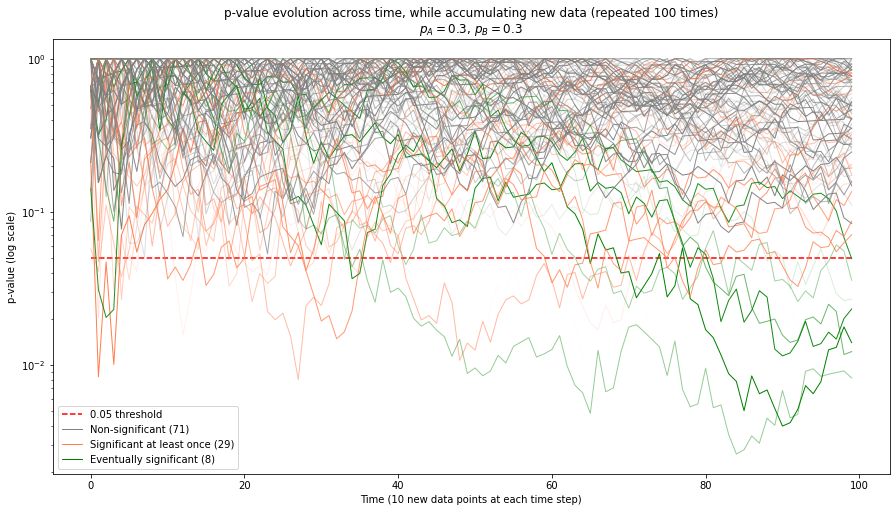

In [10]:
plot_pvalue_trajectories(trajectories_h0, .3, .3)

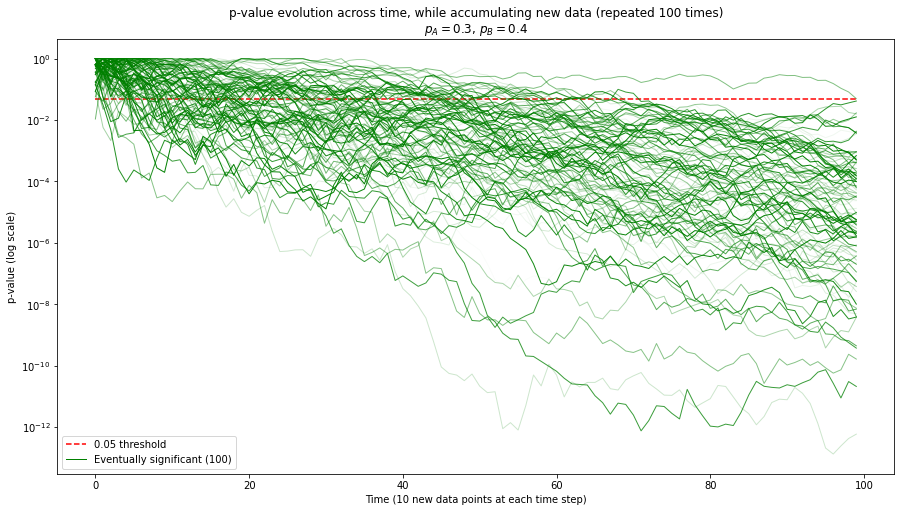

In [11]:
plot_pvalue_trajectories(trajectories_h1, .3, .4)

## Bayesian approach using ROPE (Region Of Practical Equivalence) 

In [12]:
def plot_rope_decisions(trajectories, proba_a, proba_b):
    decisions = np.array([traj.decision for traj in trajectories])
    plt.figure(figsize=(8, 5))
    plt.title(f'ROPE decision evolution across time,'
              f'while accumulating new data (repeated {len(trajectories)} times)\n'
              f'$p_A = {proba_a}$, $p_B = {proba_b}$')
    plt.xlabel('Time (10 new data points at each time step)')
    plt.ylabel('p-value (log scale)')
    plt.plot((decisions == 1).sum(axis=0), label='B is practically better', color='blue')
    plt.plot((decisions == -1).sum(axis=0), label='A is practically better', color='green')
    plt.plot((decisions == 0).sum(axis=0), label='A and B are practically equivalent', color='darkgray')
    plt.plot((np.isnan(decisions)).sum(axis=0), label='Inconclusive - needs more data', color='darkorange', linestyle='dashed')
    _ = plt.legend(loc='center left')

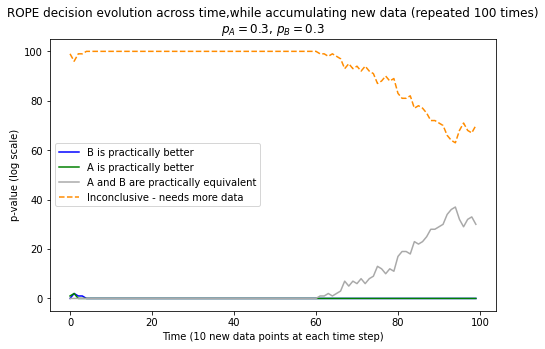

In [13]:
plot_rope_decisions(trajectories_h0, .3, .3)

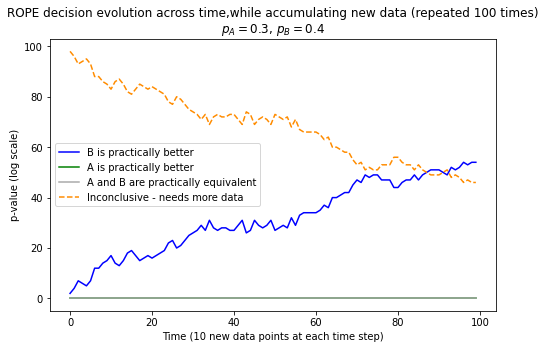

In [14]:
plot_rope_decisions(trajectories_h1, .3, .4)

# A practical example - with a continuous outcome
Involving Markov chain Monte Carlos (MCMC) sampling, easy with PyMC3

## Generate the data

In [15]:
# for i in range(10000):
#     np.random.seed(i)
#     samples_a = np.random.normal(loc=10, scale=5, size=1000)
#     samples_b = np.random.normal(loc=10, scale=5, size=1000)
#     _, pvalue = sp.stats.ttest_ind(samples_a, samples_b, equal_var=False)
#     if pvalue <= .05:
#         print(pvalue, i)
#         break

In [16]:
np.random.seed(3)
samples_a = np.random.normal(loc=10, scale=5, size=1000)
samples_b = np.random.normal(loc=10, scale=5, size=1000)

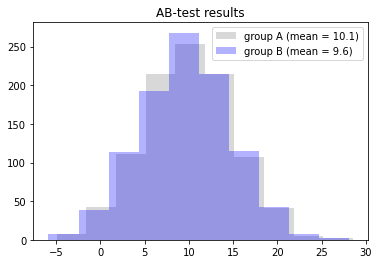

In [17]:
plt.title(f'AB-test results')
plt.hist(samples_a, color='gray', alpha=.3, label=f'group A (mean = {samples_a.mean():.1f})')
plt.hist(samples_b, color='blue', alpha=.3, label=f'group B (mean = {samples_b.mean():.1f})')
_ = plt.legend()

## p-value analysis

In [18]:
cm = sms.CompareMeans(sms.DescrStatsW(samples_b), sms.DescrStatsW(samples_a))
cm.summary(alpha=.05, usevar='unequal')

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-0.4699,0.226,-2.080,0.038,-0.913,-0.027


## Build the model

In [19]:
samples_all = np.concatenate([samples_a, samples_b])

def build_model(samples, suffix='a'):
    mean = pm.Normal("mean" + suffix, mu=samples_all.mean(), sigma=samples_all.std() * 2)
    std = pm.Uniform("std" + suffix, lower=1, upper=20)
    observed = pm.Normal("observed" + suffix, mu=mean, sigma=std, observed=samples)
    return observed

with pm.Model() as model:
    observed_a = build_model(samples_a, "_a")
    observed_b = build_model(samples_b, "_b")
    difference = pm.Deterministic("difference", model.mean_b - model.mean_a)
    rel_increase = pm.Deterministic("relative increase", difference / model.mean_a)

## Sample parameters posterior

In [20]:
with model:
    trace = pm.sample(draws=1000, chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [std_b, mean_b, std_a, mean_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


## Checks

### Convergence

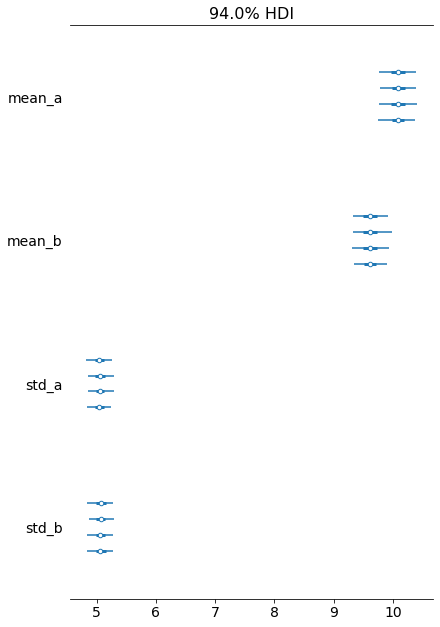

In [21]:
with model:
    pm.forestplot(trace, var_names=["mean_a", "mean_b", "std_a", "std_b"])

### Prior predictive check

In [22]:
with model:
    prior_predictive = pm.sample_prior_predictive(var_names=["observed_a", "observed_b"])

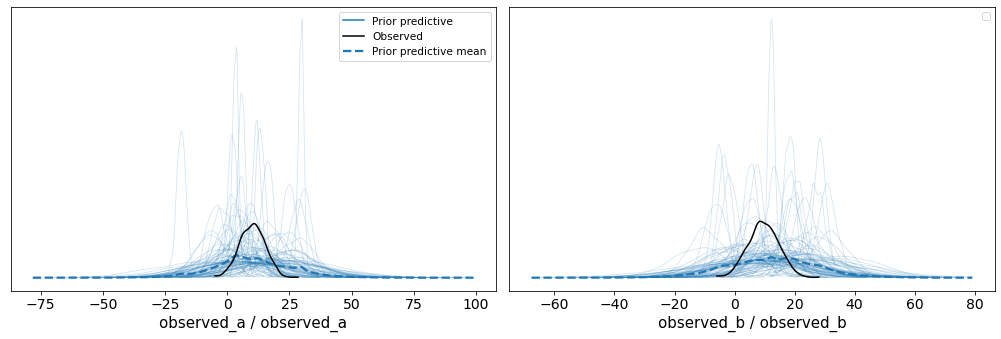

In [23]:
az.plot_ppc(az.from_pymc3(prior=prior_predictive, model=model), num_pp_samples=100, group="prior");

### Posterior predictive check

In [24]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["observed_a", "observed_b"])

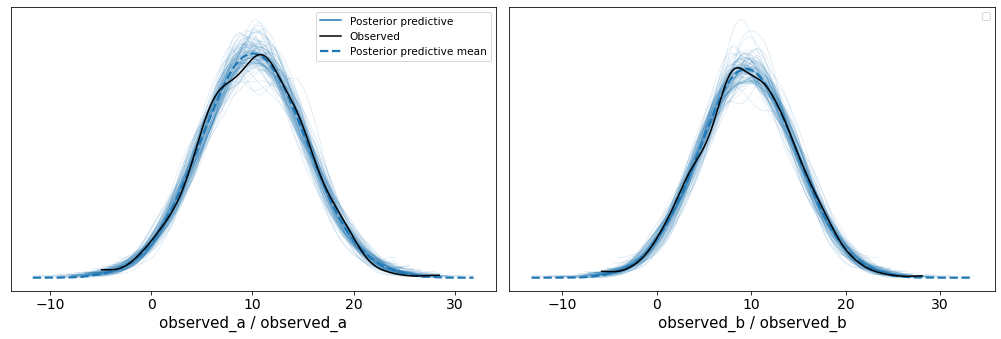

In [25]:
_ = az.plot_ppc(az.from_pymc3(posterior_predictive=posterior_predictive, model=model),
                num_pp_samples=100, alpha=.15)

### Results and decision

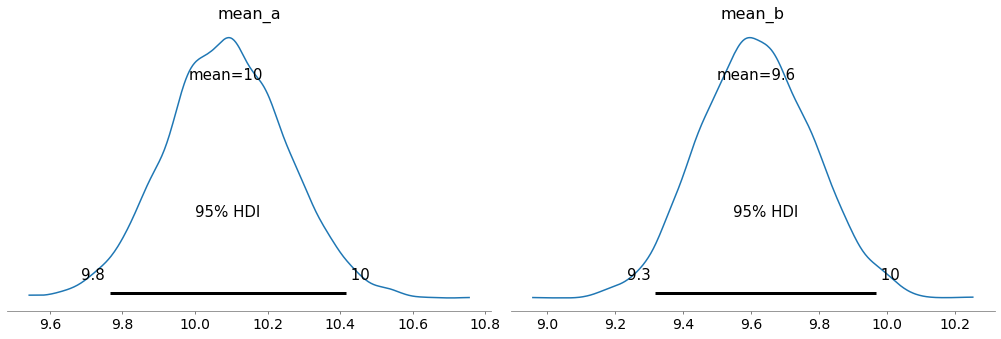

In [26]:
with model:
    _ = pm.plot_posterior(trace, var_names=["mean_a", "mean_b"], hdi_prob=.95)

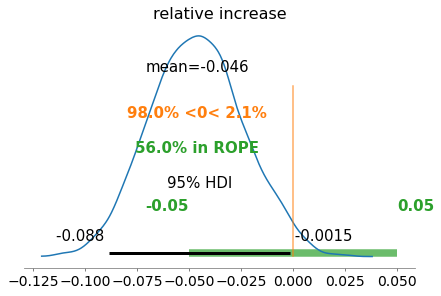

In [27]:
with model:
    az.plot_posterior(trace, var_names=["relative increase"], hdi_prob=.95, ref_val=0, rope=(-.05, .05))